### Demo for using fuzzy-mining
#### created by Shray Pungaliya (forked from Fanqing Xu), supervised by Mohammad Reza Rajati

In [1]:
import fuzzy_mining as fm
import pandas as pd
from sklearn.model_selection import train_test_split
from skfuzzy import control as ctrl
import skfuzzy as fuzz
from skfuzzy import fuzzy_sub
# %matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
from dataclasses import dataclass
import numpy as np

import sys, importlib
importlib.reload(sys.modules['fuzzy_mining'])
import fuzzy_mining as fm

/Users/shray/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# import dataset as pandas dataframe
# we use a simple regression problem dataset for example:
# https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength
dataset = pd.read_excel('./data/Concrete_Data.xls')

In [3]:
# split the dataset into training/test set as you like
X_train, X_test = train_test_split(dataset, test_size=0.3, random_state=0)

In [4]:
# specify the names for Antecedents and Consequent
column_names = ["cement", "slag", "ash", "water", "superplasticizer", "coarse_aggregate", "fine_aggregate", "age", "strength"]

In [5]:
# create the Fuzzy Object using training dataset and names
concrete = fm.FuzzyObj(X_train, column_names)

In [6]:
# define the range of each component
concrete.create_fuzzy_variables()

Fuzzy variables are created with 8 Antecedents and 1 Consequent:
[Antecedent: cement, Antecedent: slag, Antecedent: ash, Antecedent: water, Antecedent: superplasticizer, Antecedent: coarse_aggregate, Antecedent: fine_aggregate, Antecedent: age, Consequent: strength]


Fuzzification is done. View membership function using .view(name, region):
Regions are: ['low', 'medium', 'high']
Preview of Consequent y:



/Users/shray/.pyenv/versions/3.8.2/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


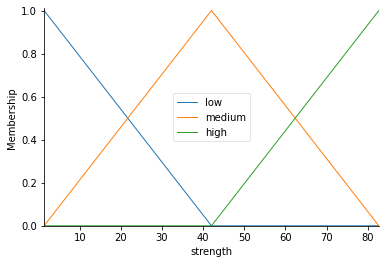

In [7]:
# fuzzify each component
# for now, only auto_fuzzify is supported and recommmended
# you can view the fuzzy region for each component
region_names = ['low', 'medium', 'high']
regionNameLen = len(region_names)
concrete.auto_fuzzify(region_names)

/Users/shray/.pyenv/versions/3.8.2/lib/python3.8/site-packages/skfuzzy/control/term.py:74: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


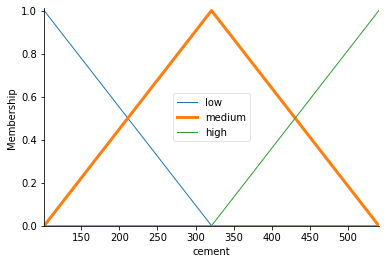

In [8]:
concrete.view("cement", 'medium')

In [9]:
# extract the rules from training data
# group the rules with same IF part together
concrete.extract()

137 unique rules(groups) are found.


In [10]:
# you can check how it looks like
# each element is in shape: [x1, x2, ..., y, y_value, rule_weight]
# 
concrete.group[2]

[['high',
  'medium',
  'low',
  'medium',
  'medium',
  'low',
  'medium',
  'low',
  'high',
  74.19451236,
  0.06528154977879154],
 ['high',
  'medium',
  'low',
  'medium',
  'medium',
  'low',
  'medium',
  'low',
  'high',
  68.29949256,
  0.08984616349965781],
 ['high',
  'medium',
  'low',
  'medium',
  'medium',
  'low',
  'medium',
  'low',
  'medium',
  55.59934464,
  0.1053815677219508]]

In [11]:
# for each group, resolve the conflicting rules
# accepted method arguments are: 'random', 'majority', 'ranked', 'WMcomplete', 'semiavg'
concrete.resolve_conflict(method='majority')

137 final rules are built.


In [12]:
# for extra dataset, like test data, there may no exist exact matched rules in rule base.
# we have to interpolate the rule base to make it work.
# accepted metric arguements are: 'Jaccard', 'plain' (for now, only nearest neigbhor method)
concrete.interp_rules(X_test, method='Jaccard')

['low', 'medium', 'low', 'medium', 'low', 'low', 'low', 'low', 'low']
9 extra rules are added after interpolation.


In [13]:
# you can check how interpolated rules are like
# each rule is in shape: [x1, x2, ..., y]
concrete.extra_rules[0]

['medium',
 'medium',
 'low',
 'medium',
 'medium',
 'high',
 'medium',
 'medium',
 'medium']

In [14]:
# you can also check how original rule base is like (which extract only from training dataset)
concrete.rule_base[0]

['medium', 'low', 'low', 'medium', 'low', 'medium', 'medium', 'low', 'medium']

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

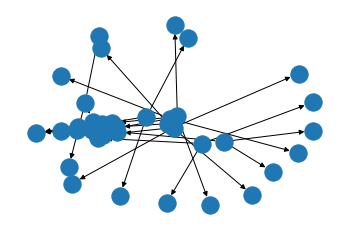

In [15]:
'''
This part can't be integrate into the package, which needs to be explicitly written, for now.
The main purpose is to use rule base and extra rules we have obtained to construct the Rule objects,
which is a must in scikit-fuzzy package.
'''

# .Rule() method also accepts Term
rules = []
ant_con = concrete.list_obj
for r in concrete.rule_base:
    rules.append(ctrl.Rule(ant_con[0][r[0]] & ant_con[1][r[1]] & ant_con[2][r[2]]
                  & ant_con[3][r[3]] & ant_con[4][r[4]] & ant_con[5][r[5]] 
                  & ant_con[6][r[6]] & ant_con[7][r[7]], ant_con[8][r[8]]))
# add extra interpolated rules
for r in concrete.extra_rules:
    rules.append(ctrl.Rule(ant_con[0][r[0]] & ant_con[1][r[1]] & ant_con[2][r[2]]
                  & ant_con[3][r[3]] & ant_con[4][r[4]] & ant_con[5][r[5]] 
                  & ant_con[6][r[6]] & ant_con[7][r[7]], ant_con[8][r[8]]))
# you can check a visualization of rule by .view() 
# (porvided by scikit-fuzzy, showing some relation between components)
rules[0].view()

In [16]:
# you can check how the final rules can be read in fuzzy IF-THEN logic

rules[0]

IF ((((((cement[medium] AND slag[low]) AND ash[low]) AND water[medium]) AND superplasticizer[low]) AND coarse_aggregate[medium]) AND fine_aggregate[medium]) AND age[low] THEN strength[medium]
	AND aggregation function : fmin
	OR aggregation function  : fmax

In [17]:
# now, we can build the fuzzy system using Rules obtained above
# this will take some time
concrete.build_system(rules)

This will take a fairly long time, caused by graph creating process which is used in scikit-fuzzy package.

Done. Time used to build fuzzy system: 32.015665 sec.


/Users/shray/.pyenv/versions/3.8.2/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


predicted y: 37.82921591276484
true y: 25.559564796
error: 12.269651116764837


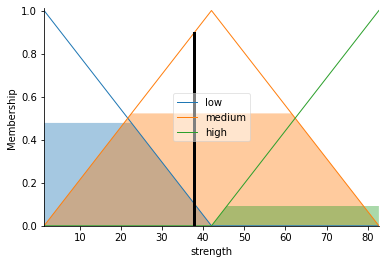

In [18]:
# take a random trial to see how crispy value of y is generated
concrete.test()

In [19]:
# compute R2 here, other method will be added if needed
R2_train = 1 - concrete.compute_error(X_train)

In [20]:
# compute R2
# an exception will raise if there is no matching rule for further debugging
R2_test = 1 - concrete.compute_error(X_test)

In [21]:
# You can then create a simple 3-layer NN for comparison
# using scikit-learn MLP implementation

from sklearn.neural_network import MLPRegressor
# separate label from X_train using above
train_X = X_train.loc[:,X_train.columns[0:len(ant_con)-1]].to_numpy()
train_y = X_train.loc[:,X_train.columns[-1]].to_numpy()
test_X = X_test.loc[:,X_test.columns[0:len(ant_con)-1]].to_numpy()
test_y = X_test.loc[:,X_test.columns[-1]].to_numpy()

regr = MLPRegressor(hidden_layer_sizes=(50,), max_iter=500, random_state=0)

regr.fit(train_X, train_y)

# using same R^2 for scoring the model
MLP_train_R2 = regr.score(train_X, train_y)
MLP_test_R2 = regr.score(test_X, test_y)

print("MLP train R^2: {}\nMLP test R^2: {}\nfuzzy train R^2: {}\nfuzzy test R^2: {}"
      .format(MLP_train_R2, MLP_test_R2, R2_train, R2_test))

MLP train R^2: 0.8331960963142437
MLP test R^2: 0.796408296104545
fuzzy train R^2: 0.9046127907131937
fuzzy test R^2: 0.9248116427058892


In [22]:
# Work by Shray Pungaliya (pungaliy) from this point forward

fuzzyObject = concrete
U = 1
transitionPairs = fuzzyObject.getDefaultTransitionPairs()
# This part is expensive because fuzzy subtraction is very slow; avoid running this more than once 
# The consequent won't change unless you change the decision variable (U)
delta_u_consequent = fuzzyObject.genSubtractionConsequent(column_names[U], transitionPairs, 'concrete')

Retrieving saved fuzzy subtraction results


In [23]:
decisionControlSystem = fuzzyObject.generateDecisionControlSystem(transitionPairs, U, delta_u_consequent)

['medium', 'medium', 'low', 'medium', 'low', 'medium', 'medium', 'low', 'low']
['high', 'low', 'low', 'medium', 'medium', 'low', 'medium', 'low', 'medium']
['high', 'medium', 'low', 'medium', 'medium', 'low', 'medium', 'low', 'high']
['medium', 'medium', 'low', 'low', 'medium', 'medium', 'medium', 'low', 'high']
['medium', 'medium', 'low', 'medium', 'low', 'high', 'medium', 'low', 'low']
['low', 'medium', 'low', 'medium', 'low', 'medium', 'low', 'low', 'low']
['low', 'low', 'medium', 'medium', 'low', 'medium', 'medium', 'low', 'low']
['medium', 'medium', 'low', 'medium', 'medium', 'medium', 'low', 'low', 'medium']
['medium', 'high', 'low', 'medium', 'medium', 'medium', 'low', 'low', 'high']
['high', 'medium', 'low', 'low', 'high', 'low', 'medium', 'low', 'high']
['medium', 'low', 'medium', 'low', 'medium', 'high', 'medium', 'medium', 'high']
['high', 'low', 'low', 'low', 'low', 'medium', 'medium', 'low', 'high']
['medium', 'medium', 'medium', 'medium', 'medium', 'low', 'medium', 'low',

In [24]:

# train
new_train_X = fuzzyObject.generateNewX(train_X, decisionControlSystem, U)
new_train_y = regr.predict(new_train_X)
train_delta_ys = np.subtract(new_train_y, train_y)

# test
new_test_X = fuzzyObject.generateNewX(test_X, decisionControlSystem, U)
new_test_y = regr.predict(new_test_X)
test_delta_ys = np.subtract(new_test_y, test_y)


Decision variable: slag
train_delta_ys
DescribeResult(nobs=721, minmax=(-26.559209654993936, 34.2736824957618), mean=8.034717204508445, variance=85.04188107847719, skewness=-0.32196918199115176, kurtosis=0.48872912598395946)


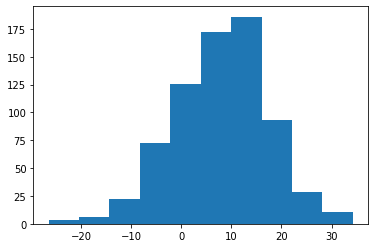

test_delta_ys
DescribeResult(nobs=309, minmax=(-21.914546137054458, 35.21790590199018), mean=8.39273763732184, variance=92.6864693149095, skewness=-0.16745031256053483, kurtosis=-0.05890941297458374)


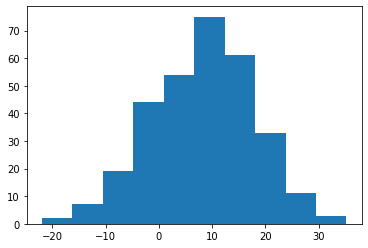

In [25]:
from scipy import stats

print("Decision variable: " + column_names[U])

print("train_delta_ys")
plt.hist(train_delta_ys)
print(stats.describe(train_delta_ys))
plt.show()

print("test_delta_ys")
plt.hist(test_delta_ys)
print(stats.describe(test_delta_ys))
plt.show()